# Team_06 — Multimodal RAG (Improved)

In [ ]:
!pip -q install pymupdf pdfplumber sentence-transformers faiss-cpu rank_bm25 openai tiktoken pandas rapidfuzz

In [ ]:
!pip install -U sentence-transformers[all]

In [ ]:
import os, re, uuid, random
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd

import fitz
import pdfplumber
from sentence_transformers import SentenceTransformer
try:
    from sentence_transformers import CrossEncoder
    CROSS_OK = True
except Exception:
    CrossEncoder = None
    CROSS_OK = False

from rank_bm25 import BM25Okapi
import faiss
from rapidfuzz import fuzz

from openai import OpenAI

random.seed(42); np = __import__('numpy'); np.random.seed(42)


DATA_DIR = Path("/content")
PDF_PATH = DATA_DIR / "WHO_document.pdf"
QUESTIONS_CSV = DATA_DIR / "266_lab2_questions.csv"
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = "cpu"
print("Device:", DEVICE)

Device: cpu


In [ ]:
FIG_RE = re.compile(r"(?:Figure|Fig\.?|Figs\.?)\s*([0-9]+(?:[\.-][0-9]+)*)", re.I)
TAB_RE = re.compile(r"(?:Table|Tab\.?)\s*([0-9]+(?:[\.-][0-9]+)*)", re.I)
HEAD_RE = re.compile(r"^([A-Z][A-Z \-0-9]{6,}.*|[0-9]+\.[0-9.]*\s+.+)$")

@dataclass
class Node:
    id: str
    type: str
    page: int
    text: str
    caption: str = ""
    number: str = ""
    section_path: str = ""
    meta: dict = None

def extract_pdf(path: Path):
    text_nodes, vis_nodes = [], []
    with pdfplumber.open(str(path)) as pdf:
        for pageno, page in enumerate(pdf.pages, start=1):
            txt = page.extract_text() or ""
            for ln in txt.splitlines():
                fl = FIG_RE.search(ln); tl = TAB_RE.search(ln)
                if fl:
                    vis_nodes.append(Node(str(uuid.uuid4()), "figure", pageno, ln, ln, fl.group(1), meta={"source":"caption"}))
                if tl:
                    vis_nodes.append(Node(str(uuid.uuid4()), "table", pageno, ln, ln, tl.group(1), meta={"source":"caption"}))
            try:
                tables = page.extract_tables() or []
            except Exception:
                tables = []
            for tbl in tables:
                flat = "\\n".join([", ".join([c or "" for c in row]) for row in tbl])
                vis_nodes.append(Node(str(uuid.uuid4()), "table", pageno, flat, caption="", number="", meta={"source":"table"}))
    doc = fitz.open(str(path))
    for pageno in range(len(doc)):
        page = doc[pageno]
        blocks = page.get_text("blocks")
        blocks.sort(key=lambda b: (round(b[1],1), round(b[0],1)))
        for b in blocks:
            t = (b[4] or "").strip()
            if not t: continue
            if FIG_RE.match(t) or TAB_RE.match(t): continue
            text_nodes.append(Node(str(uuid.uuid4()), "text", pageno+1, t))
    return text_nodes, vis_nodes

text_nodes, vis_nodes = extract_pdf(PDF_PATH)
print("Text blocks:", len(text_nodes), "Visual nodes:", len(vis_nodes))

Text blocks: 1454 Visual nodes: 126


In [ ]:
def chunk_text(nodes: List[Node], max_words=250, overlap=50):
    chunks = []
    current = []
    sec_path = []
    def flush():
        nonlocal current
        if not current: return
        text = " ".join(current).strip()
        words = text.split()
        start = 0
        while start < len(words):
            end = min(len(words), start+max_words)
            piece = " ".join(words[start:end])
            chunks.append(piece)
            start = max(end-overlap, end)
        current = []
    for n in nodes:
        ln = n.text.strip()
        if HEAD_RE.match(ln):
            flush()
            sec_path = (sec_path + [re.sub(r"\s+"," ", ln).strip()])[-3:]
            current.append(" | ".join(sec_path))
        else:
            current.append(ln)
    flush()
    return chunks

chunks = chunk_text(text_nodes)
print("Chunks:", len(chunks))

Chunks: 103


In [ ]:
# Hybrid index
bm25 = BM25Okapi([t.lower().split() for t in chunks])
emb_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embs = emb_model.encode(chunks, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)
index = faiss.IndexFlatIP(embs.shape[1]); index.add(embs.astype("float32"))

reranker = None
if CROSS_OK:
    try:
        reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
    except Exception:
        reranker = None


In [ ]:
cap_texts, cap_keys = [], []
for n in vis_nodes:
    cap = n.caption if n.caption else n.text
    if not cap: continue
    cap_texts.append(cap)
    m = (FIG_RE.search(cap) or TAB_RE.search(cap))
    num = m.group(1) if m else (n.number or "")
    cap_keys.append((n.type, num))

cap_embs = emb_model.encode(cap_texts, convert_to_numpy=True, normalize_embeddings=True) if cap_texts else np.zeros((0, emb_model.get_sentence_embedding_dimension()))

In [ ]:
def rrf_fuse(query: str, topk=12):
    import numpy as np
    qv = emb_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    D, I = index.search(qv.astype("float32"), topk*4)
    dense = {int(i): r for r, i in enumerate(I[0])}
    scores = bm25.get_scores(query.lower().split())
    sp_idx = np.argsort(scores)[::-1][:topk*4]
    sparse = {int(i): r for r, i in enumerate(sp_idx)}
    cand = set(dense)|set(sparse)
    fused = []
    for i in cand:
        s = (1/(60 + dense.get(i, 10**6))) + (1/(60 + sparse.get(i, 10**6)))
        fused.append((i, s))
    fused.sort(key=lambda x: x[1], reverse=True)
    fused = fused[:topk*2]
    if reranker is not None:
        pairs = [[query, chunks[i]] for i,_ in fused]
        rr = reranker.predict(pairs)
        fused = [(idx, float(sc)) for (idx,_), sc in zip(fused, rr)]
        fused.sort(key=lambda x: x[1], reverse=True)
    return [i for i,_ in fused[:topk]]

In [ ]:
from openai import OpenAI

def query_rewrite(client, q: str) -> str:
    try:
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role":"system","content":"Rewrite the question for better document retrieval. Expand acronyms and add synonyms. Output one short query."},
                      {"role":"user","content":q}],
            temperature=0.0, max_tokens=50,
        )
        return resp.choices[0].message.content.strip()
    except Exception:
        return q

In [ ]:
def sentence_rank(question: str, context_texts: List[str], topn=2):
    import re, numpy as np
    sents = []
    for t in context_texts:
        for s in re.split(r"(?<=[.!?])\s+", t):
            s2 = s.strip()
            if 8 <= len(s2) <= 400:
                sents.append(s2)
    if not sents:
        return []
    bm = BM25Okapi([s.lower().split() for s in sents])
    sc = bm.get_scores(question.lower().split())
    order = np.argsort(sc)[::-1][:topn*4]
    cands = []
    for idx in order:
        s = sents[idx]
        fz = fuzz.partial_ratio(question.lower(), s.lower())
        cands.append((s, float(sc[idx]) + 0.01*fz))
    picked = []
    for s,_ in sorted(cands, key=lambda x:x[1], reverse=True):
        if all(fuzz.token_set_ratio(s, p) < 85 for p in picked):
            picked.append(s)
        if len(picked)>=topn:
            break
    return picked[:topn]

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


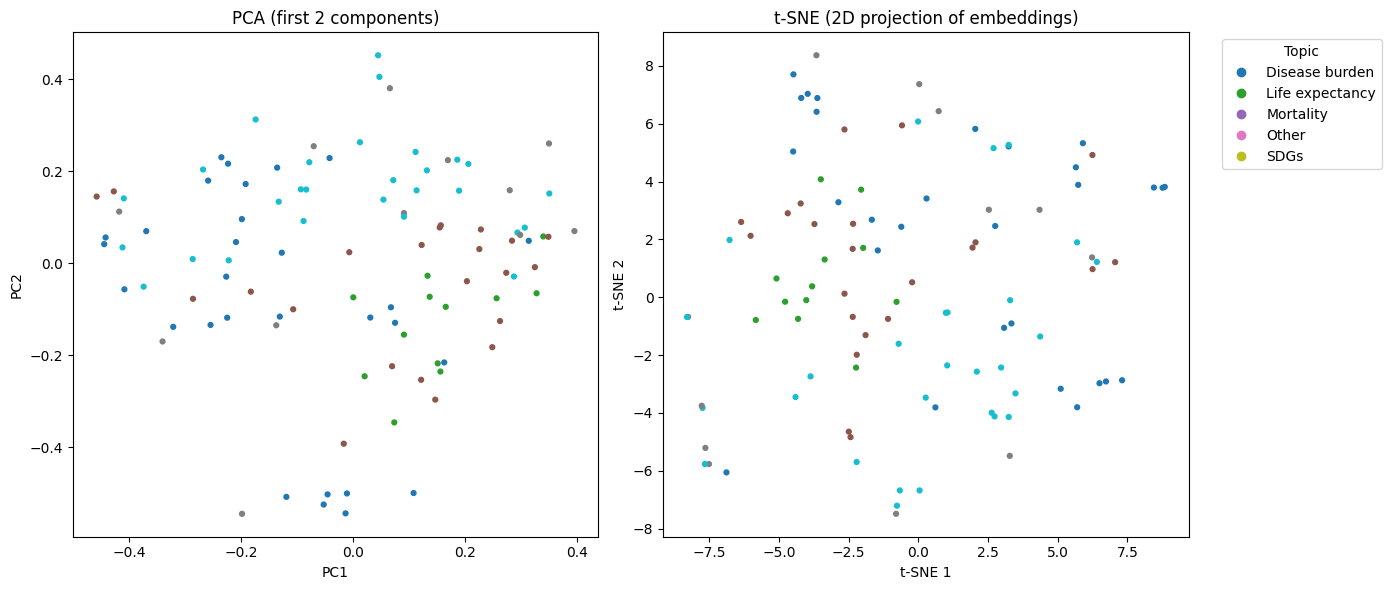

In [ ]:
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# label each chunk by topic keyword
labels = []
for ch in chunks:
    txt = ch.lower()
    if "life expectancy" in txt:
        labels.append("Life expectancy")
    elif "mortality" in txt:
        labels.append("Mortality")
    elif "disease" in txt or "infection" in txt:
        labels.append("Disease burden")
    elif "sdg" in txt or "goal" in txt:
        labels.append("SDGs")
    else:
        labels.append("Other")

# Encode colors by label
unique_labels = sorted(set(labels))
color_map = {lbl:i for i,lbl in enumerate(unique_labels)}
colors = [color_map[lbl] for lbl in labels]

# Dimensionality reduction
pca = PCA(n_components=50, random_state=42)
reduced_pca = pca.fit_transform(embs)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1500)
reduced_tsne = tsne.fit_transform(reduced_pca)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
scatter1 = axs[0].scatter(reduced_pca[:, 0], reduced_pca[:, 1],
                           c=colors, cmap='tab10', s=12)
axs[0].set_title("PCA (first 2 components)")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

scatter2 = axs[1].scatter(reduced_tsne[:, 0], reduced_tsne[:, 1],
                           c=colors, cmap='tab10', s=12)
axs[1].set_title("t-SNE (2D projection of embeddings)")
axs[1].set_xlabel("t-SNE 1")
axs[1].set_ylabel("t-SNE 2")

# Single legend outside
handles, _ = scatter2.legend_elements(num=len(unique_labels))
axs[1].legend(handles, unique_labels, title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
def pick_figures(question: str, support_idxs: List[int]) -> List[str]:
    mentions = []
    for i in support_idxs:
        m1 = FIG_RE.findall(chunks[i])
        m2 = TAB_RE.findall(chunks[i])
        for m in m1: mentions.append(m)
        for m in m2: mentions.append(m)
    if mentions:
        freq = {}
        for n in mentions:
            k = re.sub(r"[^0-9\.\-]", "", n)
            freq[k] = freq.get(k,0)+1
        return list(dict.fromkeys([k for k,_ in sorted(freq.items(), key=lambda x:x[1], reverse=True)]))[:3]
    if len(cap_texts)==0:
        return []
    qv = emb_model.encode([question], convert_to_numpy=True, normalize_embeddings=True)
    sims = (qv @ cap_embs.T)[0]
    top = np.argsort(sims)[::-1][:3]
    out = []
    for j in top:
        num = cap_keys[j][1]
        if num:
            out.append(re.sub(r"[^0-9\.\-]", "", num))
    return out[:3]

In [ ]:
SYSTEM_PROMPT = '''Answer using ONLY the provided text. Prefer verbatim phrases from the snippets.
If a figure or table number appears in the snippets, cite it as "Figure X" or "Table Y".
Keep answers to 1–2 sentences. Do not introduce new facts.'''

def generate_answer(client, question: str, support_texts: List[str], extractive_hint: List[str]) -> str:
    lead = "\\n".join(f"- {s}" for s in extractive_hint if s)
    ctx = "\\n\\n".join(support_texts[:6])
    user = f"Question: {question}\\n\\nTop sentences (copy if correct):\\n{lead}\\n\\nOther snippets:\\n{ctx}"
    try:
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role":"system","content":SYSTEM_PROMPT},
                      {"role":"user","content":user}],
            temperature=0.15, max_tokens=150,
        )
        return resp.choices[0].message.content.strip()
    except Exception:
        return " ".join(extractive_hint)[:400]

In [ ]:
def answer_one(client, q: str):
    rq = query_rewrite(client, q)
    idxs = rrf_fuse(q + " " + rq, topk=10)
    support = [chunks[i] for i in idxs]
    hint = sentence_rank(q, support, topn=2)
    ans = generate_answer(client, q, support, hint)
    figs = pick_figures(q, idxs)
    refs = ", ".join(figs) if figs else "0"
    return ans, refs

In [ ]:
client = OpenAI(api_key=api_key)

dfq = pd.read_csv(QUESTIONS_CSV)
rows = []
for _, r in dfq.iterrows():
    ans, refs = answer_one(client, r["question"])
    rows.append({
        "id": int(r["id"]),
        "conversation_id": int(r["conversation_id"]),
        "question_id": int(r["question_id"]),
        "answer": ans,
        "figure_references": refs if refs else "0"
    })

In [ ]:
out_df = pd.DataFrame(rows)
OUT_DIR.mkdir(exist_ok=True, parents=True)
out_path = OUT_DIR / "submission_team06.csv"
out_df.to_csv(out_path, index=False)
print("Saved:", out_path)
out_df.head()

Saved: outputs/submission_team06.csv


,id,conversation_id,question_id,answer,figure_references
0,1,1,1,"During the COVID-19 pandemic, global life expe...","1.2, 1.1, 1.3"
1,2,1,2,The hardest hit regions by the pandemic were t...,"1.3, 2.12, 2.17"
2,3,1,3,"During the COVID-19 pandemic, there was an ""ab...","1.4, 1.7, 1.8"
3,4,2,1,"In 2021, the top causes of death globally incl...","1.12, 1.4, 1.5"
4,5,2,2,"Yes, COVID-19 ranked differently across region...","2.12, 1.5, 1.6"
